In [1]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import pyavm
import numpy as np
import PIL
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u

# do this before importing webb
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
from jwst.datamodels import ImageModel

from jwst.pipeline import calwebb_image3
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

from jwst.datamodels import ImageModel

import jwst.datamodels
from jwst import datamodels

In [2]:
basepath = '/orange/adamginsburg/jwst/cloudc/'
cat = Table.read(f'{basepath}/catalogs/miri_combined_crowdsource_nsky1_photometry_tables_merged.fits')

In [10]:
cat.columns

<TableColumns names=('skycoord_ref','skycoord_ref_filtername','sep_f410m','id_f410m','skycoord_f410m','x_f410m','y_f410m','flux_f410m','passno_f410m','dx_f410m','dy_f410m','dflux_f410m','qf_f410m','rchi2_f410m','fracflux_f410m','fluxlbs_f410m','dfluxlbs_f410m','fwhm_f410m','spread_model_f410m','dspread_model_f410m','fluxiso_f410m','xiso_f410m','yiso_f410m','flags_f410m','sky_f410m','mask_f410m','flux_jy_f410m','eflux_jy_f410m','mag_ab_f410m','emag_ab_f410m','near_saturated_f410m_f410m','replaced_saturated_f410m','sep_f212n','id_f212n','skycoord_f212n','x_f212n','y_f212n','flux_f212n','passno_f212n','dx_f212n','dy_f212n','dflux_f212n','qf_f212n','rchi2_f212n','fracflux_f212n','fluxlbs_f212n','dfluxlbs_f212n','fwhm_f212n','spread_model_f212n','dspread_model_f212n','fluxiso_f212n','xiso_f212n','yiso_f212n','flags_f212n','sky_f212n','mask_f212n','flux_jy_f212n','eflux_jy_f212n','mag_ab_f212n','emag_ab_f212n','near_saturated_f212n_f212n','replaced_saturated_f212n','sep_f466n','id_f466n','sk

In [3]:
cat[cat['real_miri_f2550w'] == True]

<Table length=149>
             skycoord_ref              skycoord_ref_filtername       sep_f410m        id_f410m ... emag_ab_f2550w   sep_f2550w_f2550w    id_f2550w_f2550w
               deg,deg                                                  deg                    ...                         deg                           
               SkyCoord                         bytes5                float64          int64   ...    float32            float64              int64      
-------------------------------------- ----------------------- ---------------------- -------- ... -------------- ---------------------- ----------------
266.56516698876607,-28.575926410662923                   f405n 2.8724416149620445e-05    83298 ...   0.0044405675   0.011833786138100289            40187
 266.5639821227188,-28.587426139932706                   f405n 3.5093785556739935e-05   158843 ...   0.0047175144   0.011292314961179904             6924
  266.565761627183,-28.571467767329995                   f405n 2.2444777486997262e-05   158813 ...    0.006775739    0.01133418178676148            85493
266.56358835077896,-28.591274033237454                   f405n 1.2682375634529032e-05    93211 ...   0.0032650244   0.010625568516499236            57741
266.56358835077896,-28.591274033237454                   f405n 1.2682375634529032e-05    93211 ...   0.0064943694   0.009994443004735126            57741
266.56459447936913,-28.582644705642387                   f405n  3.398171887737774e-05   124328 ...    0.002161702   0.009887622741834861            73731
   266.562951757118,-28.59690941058646                   f405n 3.9170081246154254e-05    12064 ...   0.0010972216   0.009279866844496408            85496
  266.5639170243351,-28.58900258341442                   f405n 2.1170848009722883e-05   158834 ...    0.005154313   0.009337680990112633            40151
   266.565593021321,-28.57226200448411                   f405n  3.626679180996143e-05   158859 ...    0.008508294   0.009629594106745343            40193
   266.562951757118,-28.59690941058646                   f405n 3.9170081246154254e-05    12064 ...   0.0029717656   0.008928207460462535            85496
 266.5639821227188,-28.587426139932706                   f405n 3.5093785556739935e-05   158843 ...    0.007113319   0.008640883291507983             6924
   266.565593021321,-28.57226200448411                   f405n  3.626679180996143e-05   158859 ...   0.0008846453   0.008351718271254738            40193
  266.5653653931621,-28.57416390200198                   f405n  3.210588973274283e-05    83343 ...   0.0032722603    0.00806710377757795            73752
 266.56490836305784,-28.57868027338451                   f405n 1.8839968809377625e-05    12075 ...   0.0022400348   0.006993177635807507            85498
266.56278992416424,-28.598336131975984                   f405n 3.1261705439495126e-05   124395 ...  0.00034370122   0.006319146458015372            73750
                                   ...                     ...                    ...      ... ...            ...                    ...              ...
  266.5710840583748,-28.57991333556111                   f405n  5.038923577868162e-06    10932 ...    0.012476643 1.7480358109137462e-05            37177
  266.5717627175287,-28.60011291481519                   f405n  5.945374496824359e-06    10182 ...    0.012458245  2.011854598968186e-05             5810
 266.5762940563077,-28.579938118739594                   f405n  5.115617583025945e-06     9443 ...   0.0060899733  2.113657783180158e-05            53818
266.57739408147387,-28.575283617649724                   f405n 3.5767208880341663e-06     9267 ...   0.0066226292  2.411818147024601e-05            53578
 266.5760618857846,-28.596861900464816                   f405n   3.94305049966486e-06     8982 ...   0.0049958434 3.8855944149018265e-05            53179
 266.5781335634926,-28.578947320407536                   f405n 2.7236200801902068e-05    66414 ...     0.00508913  0.00028318095312

In [3]:
cat_real = cat['real_miri_f2550w'] == True
cat_sep = cat['sep_f2550w_f2550w'] < 4.1666667e-5
cat_mask = np.logical_and(cat_real, cat_sep)

In [4]:
cat_use = cat[cat_mask]
crds_use = cat_use['skycoord_ref']
cat_use[0]

<Row index=0>
             skycoord_ref             skycoord_ref_filtername       sep_f410m        id_f410m             skycoord_f410m                  x_f410m           y_f410m      flux_f410m passno_f410m   dx_f410m    dy_f410m   dflux_f410m  qf_f410m  rchi2_f410m fracflux_f410m fluxlbs_f410m dfluxlbs_f410m fwhm_f410m spread_model_f410m dspread_model_f410m fluxiso_f410m      xiso_f410m           yiso_f410m      flags_f410m sky_f410m mask_f410m flux_jy_f410m eflux_jy_f410m mag_ab_f410m emag_ab_f410m near_saturated_f410m_f410m replaced_saturated_f410m       sep_f212n       id_f212n             skycoord_f212n                  x_f212n           y_f212n      flux_f212n passno_f212n  dx_f212n    dy_f212n  dflux_f212n  qf_f212n rchi2_f212n fracflux_f212n fluxlbs_f212n dfluxlbs_f212n fwhm_f212n spread_model_f212n dspread_model_f212n fluxiso_f212n     xiso_f212n          yiso_f212n     flags_f212n sky_f212n mask_f212n flux_jy_f212n eflux_jy_f212n mag_ab_f212n emag_ab_f212n near_saturated_f212n_f212n replaced_saturated_f212n       sep_f466n        id_f466n             skycoord_f466n                  x_f466n            y_f466n       flux_f466n passno_f466n   dx_f466n    dy_f466n  dflux_f466n qf_f466n rchi2_f466n fracflux_f466n fluxlbs_f466n dfluxlbs_f466n fwhm_f466n spread_model_f466n dspread_model_f466n fluxiso_f466n      xiso_f466n         yiso_f466n     flags_f466n sky_f466n mask_f466n flux_jy_f466n eflux_jy_f466n mag_ab_f466n emag_ab_f466n near_saturated_f466n_f466n replaced_saturated_f466n sep_f405n id_f405n             skycoord_f405n                 x_f405n            y_f405n       flux_f405n passno_f405n   dx_f405n    dy_f405n  dflux_f405n qf_f405n rchi2_f405n fracflux_f405n fluxlbs_f405n dfluxlbs_f405n fwhm_f405n spread_model_f405n dspread_model_f405n fluxiso_f405n     xiso_f405n         yiso_f405n     flags_f405n sky_f405n mask_f405n flux_jy_f405n eflux_jy_f405n mag_ab_f405n emag_ab_f405n near_saturated_f405n_f405n replaced_saturated_f405n       sep_f187n        id_f187n            skycoord_f187n                 x_f187n           y_f187n      flux_f187n passno_f187n   dx_f187n    dy_f187n  dflux_f187n qf_f187n rchi2_f187n fracflux_f187n fluxlbs_f187n dfluxlbs_f187n fwhm_f187n spread_model_f187n dspread_model_f187n fluxiso_f187n      xiso_f187n         yiso_f187n     flags_f187n sky_f187n mask_f187n flux_jy_f187n eflux_jy_f187n mag_ab_f187n emag_ab_f187n near_saturated_f187n_f187n replaced_saturated_f187n       sep_f182m        id_f182m             skycoord_f182m                 x_f182m           y_f182m       flux_f182m passno_f182m   dx_f182m     dy_f182m  dflux_f182m  qf_f182m  rchi2_f182m fracflux_f182m fluxlbs_f182m dfluxlbs_f182m fwhm_f182m spread_model_f182m dspread_model_f182m fluxiso_f182m      xiso_f182m         yiso_f182m     flags_f182m sky_f182m mask_f182m flux_jy_f182m eflux_jy_f182m mag_ab_f182m emag_ab_f182m near_saturated_f182m_f182m replaced_saturated_f182m flux_jy_410m405 mag_ab_410m405 flux_jy_405m410 mag_ab_405m410 flux_jy_182m187 mag_ab_182m187 flux_jy_187m182 mag_ab_187m182            skycoord_f2550w                  x_f2550w          y_f2550w     flux_f2550w passno_f2550w dx_f2550w   dy_f2550w  dflux_f2550w qf_f2550w rchi2_f2550w fracflux_f2550w fluxlbs_f2550w dfluxlbs_f2550w fwhm_f2550w spread_model_f2550w dspread_model_f2550w fluxiso_f2550w     xiso_f2550w          yiso_f2550w      flags_f2550w sky_f2550w mask_f2550w real_miri_f2550w flux_jy_f2550w eflux_jy_f2550w mag_ab_f2550w emag_ab_f2550w   sep_f2550w_f2550w    id_f2550w_f2550w
               deg,deg                                                 deg                                   deg,deg                                                                                                                                                                                                                                                                                                                                      Jy            Jy                     

In [5]:
mir = fits.open('/orange/adamginsburg/jwst/cloudc/images/jw02221-o001_t001_miri_f2550w_i2d.fits')

2024-05-29 13:29:21,399 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:21,401 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



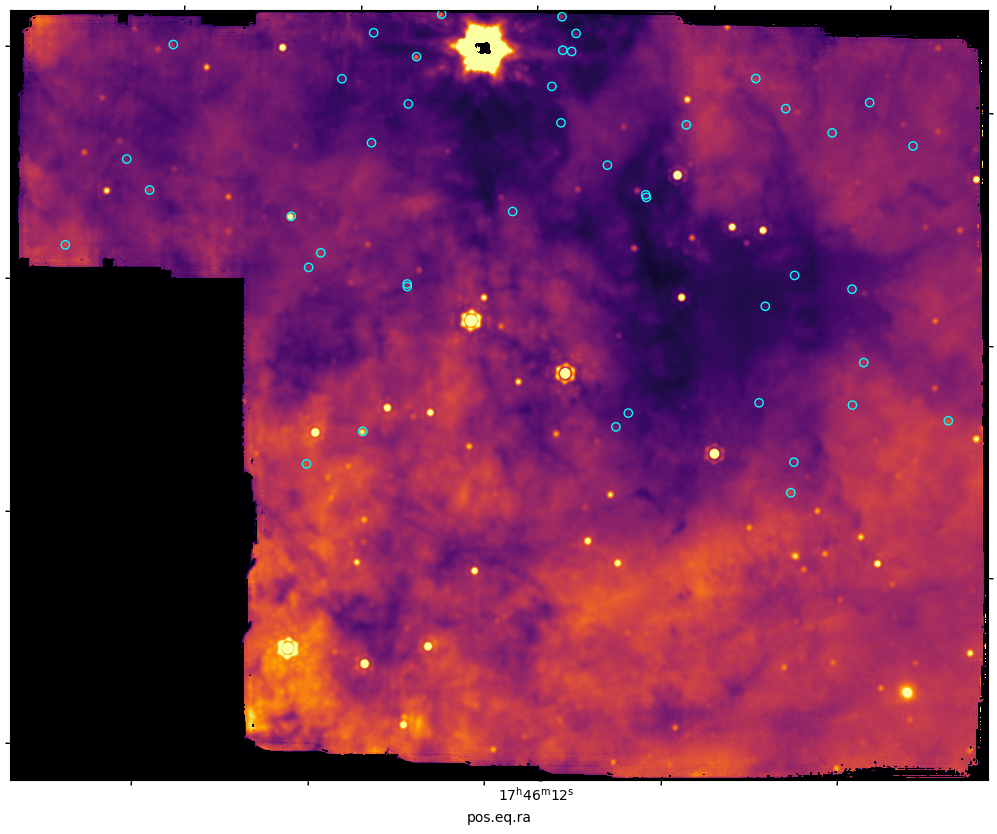

In [6]:
plt.figure(figsize=(24,10))
ax = plt.subplot(111, projection=WCS(mir['SCI'].header))
ax.imshow(mir['SCI'].data, cmap='inferno', vmin=850, vmax=1000)
ax.scatter(crds_use.ra, crds_use.dec, edgecolor='cyan', facecolor='none', transform=ax.get_transform('world'))

## Helper Functions

In [7]:
def get_cutout(filename, position, l, w):
    try: 
        hdu = fits.open(filename)#[0]
        data = hdu['SCI'].data
        head = hdu['SCI'].header
    except: 
        hdu = fits.open(filename)[0]
        data = hdu.data
        head = hdu.header

    #pixel_scale = head['PIXSCALE']*u.arcsec/u.pix
    ww = WCS(head)
    size = (l, w)
    #((l/pixel_scale).to(u.pix), (w/pixel_scale).to(u.pix))
    cutout = Cutout2D(data, position=position, size=size, wcs=ww)
    return cutout

def get_cutout_rgb(position, l, w):
    #filename_R = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    filename_R = '/orange/adamginsburg/jwst/cloudc/images/F466_reproj_merged-fortricolor.fits'
    #filename_B = '/orange/adamginsburg/jwst/cloudc/images/F187_reproj_merged-fortricolor.fits'
    filename_B = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    cutout_R = get_cutout(filename_R, position, l, w)
    cutout_B = get_cutout(filename_B, position, l, w)
    cutout_G = cutout_R.data + cutout_B.data
    rgb = np.array(
        [
            cutout_R.data,
            cutout_G,
            cutout_B.data
        ]
    ).swapaxes(0,2).swapaxes(0,1)
    rgb_scaled = np.array([
        simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
        simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=210)(rgb[:,:,1]),
        simple_norm(rgb[:,:,2], stretch='asinh', min_cut=-1, max_cut=120)(rgb[:,:,2]),
    ]).swapaxes(0,2)
    return rgb_scaled.swapaxes(0,1), cutout_R.wcs

def plot_catalog_rgb(position, l, w, catalog):
    crds_ref = catalog['skycoord_ref']
    rgb, ww = get_cutout_rgb(position, l, w)
    reg_cloudc = regions.RectangleSkyRegion(center=position, width=l, height=w)
    crds_in = crds_ref[reg_cloudc.contains(crds_ref, wcs=ww)]
    
    plt.figure(figsize=(24,10))
    ax = plt.subplot(111, projection=ww)#, origin='lower')
    ax.imshow(rgb)
    ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    plt.xticks([]);
    plt.yticks([]);
    return crds_in

# Quality Check

In [8]:
ww_mir = WCS(mir['SCI'].header)

2024-05-29 13:29:27,355 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:27,357 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



In [28]:
ww_mir.world_to_pixel(cat_use['skycoord_ref'])

(array([1240.34919036,  745.38329019, 1198.63461745,  489.619496  ,
        1364.41784515,  454.06855112, 1391.40915689,  705.98116263,
         902.32345878, 1329.97403649, 1484.18406948,  839.64732605,
         470.01063791,  541.90458726,  620.2029183 ,  646.33558992,
        1420.81657399,  781.38788431, 1310.89114159, 1421.52768591,
         728.75416326, 1031.60069197,  524.51644168,  629.36821806,
         550.15478802, 1131.57008189, 1048.18509153,  337.01881485,
        1157.00977596, 1459.32928672, 1406.33893827, 1109.48997693,
         963.70556263,  215.09320628,  872.48105908, 1302.53230202,
        1484.58747811, 1025.6033923 ,  917.50239447, 1045.15907771,
         839.29908177, 1483.9806168 ,  439.62660473,  556.27243135,
         169.37934751, 1263.34789958, 1425.5237846 ,  942.89103219,
        1038.5492857 , 1371.86610563, 1210.05717194, 1191.03902083,
        1040.68117336,  142.79139982, 1237.61075205,  303.14307706,
         624.13335957,  848.61370998,  228.23423

In [12]:
cat_use['good_match'] = np.full(len(cat_use), False)
cat_use['xcentroid'] = cat_use['x_f2550w']#ww_mir.world_to_pixel(cat_use['skycoord_ref'])[0]#cat_use['x_f405n']
cat_use['ycentroid'] = cat_use['y_f2550w']#ww_mir.world_to_pixel(cat_use['skycoord_ref'])[1]#cat_use['x_f405n']
good_matches = [4, 5, 17, 22, 28, 31, 33, 34, 36, 39, 41]
#[2, 3, 6, 13, 38, 46, 48, 56, 61, 72, 73]
for b in good_matches:
    cat_use[b]['good_match'] = True

In [13]:
cat_good_matches = cat_use[cat_use['good_match']]
cat_good_matches.write(f'{basepath}/catalogs/miri_good_matches_crowdsource_nsky1_photometry_tables_merged.fits', format='fits', overwrite=True)

0


2024-05-29 13:29:50,294 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


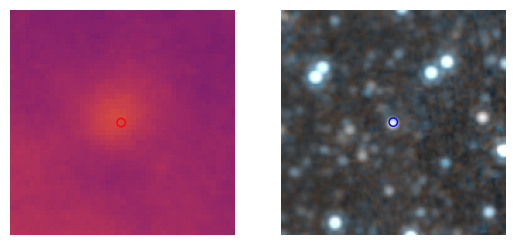

2024-05-29 13:29:50,489 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:50,492 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



1


2024-05-29 13:29:53,797 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


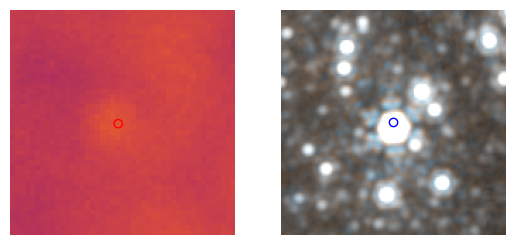

2024-05-29 13:29:53,922 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:53,924 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



2


2024-05-29 13:29:56,298 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


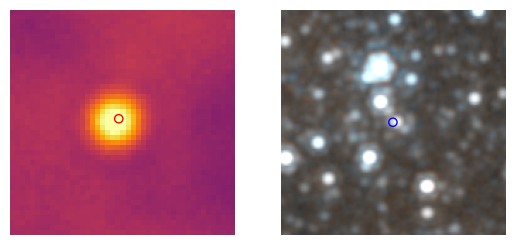

2024-05-29 13:29:56,430 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:56,432 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



3


2024-05-29 13:29:58,568 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


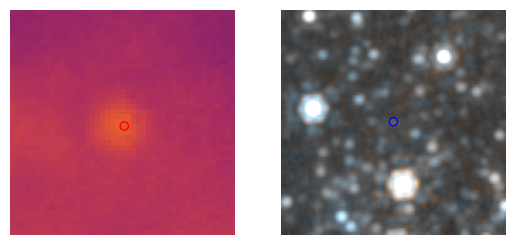

2024-05-29 13:29:58,692 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:58,694 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



4


2024-05-29 13:29:59,701 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


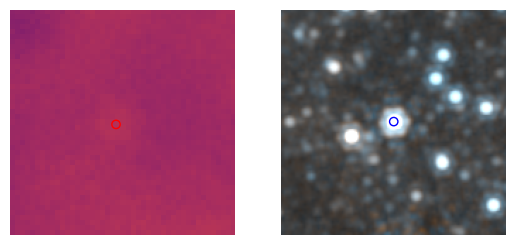

2024-05-29 13:29:59,823 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:29:59,825 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



5


2024-05-29 13:30:00,915 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


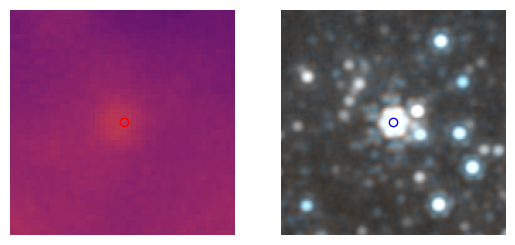

2024-05-29 13:30:01,059 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:01,061 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



6


2024-05-29 13:30:02,357 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


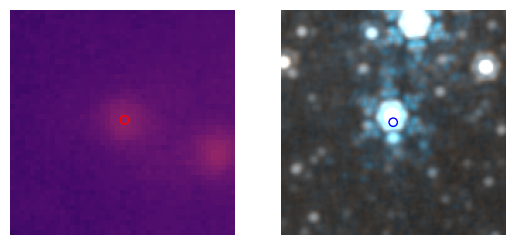

2024-05-29 13:30:02,475 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:02,477 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



7


2024-05-29 13:30:03,632 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


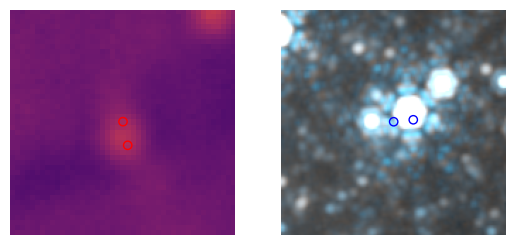

2024-05-29 13:30:03,746 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:03,749 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



8


2024-05-29 13:30:05,743 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


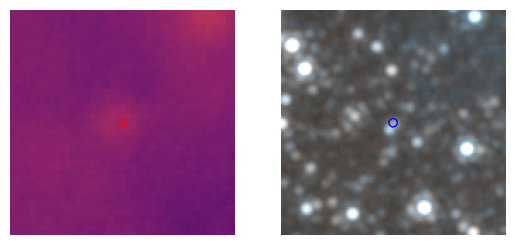

2024-05-29 13:30:05,900 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:05,902 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



9


2024-05-29 13:30:06,879 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


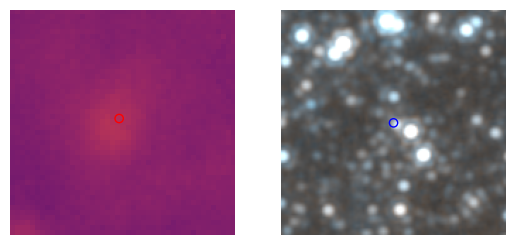

2024-05-29 13:30:06,971 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:06,973 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



10


2024-05-29 13:30:10,828 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


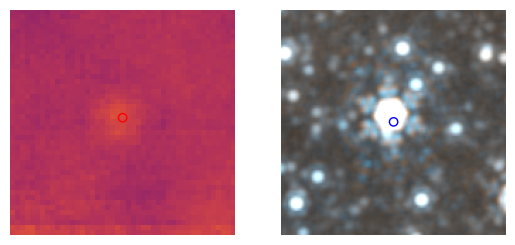

2024-05-29 13:30:10,975 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:10,977 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



11


2024-05-29 13:30:12,340 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


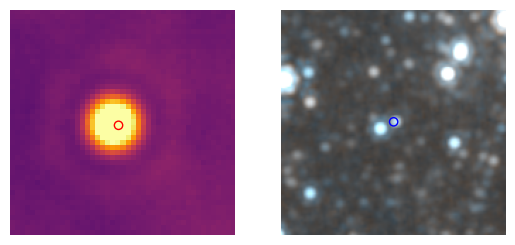

2024-05-29 13:30:12,457 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:12,459 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



12


2024-05-29 13:30:13,775 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


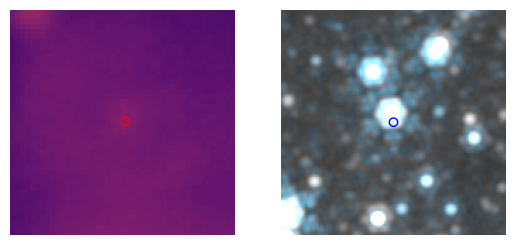

2024-05-29 13:30:13,873 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:13,875 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



13


2024-05-29 13:30:15,027 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


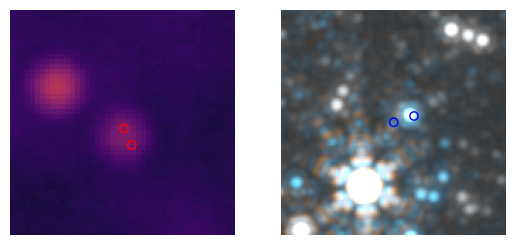

2024-05-29 13:30:15,135 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:15,137 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



14


2024-05-29 13:30:17,652 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


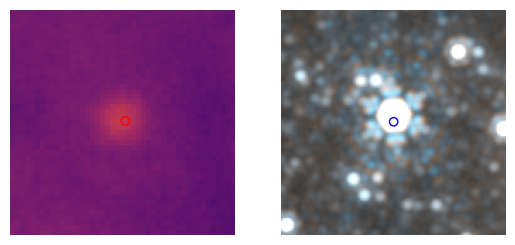

2024-05-29 13:30:17,828 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:17,855 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



15


2024-05-29 13:30:18,799 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


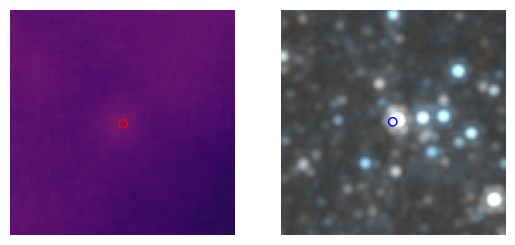

2024-05-29 13:30:18,895 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:18,897 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



16


2024-05-29 13:30:21,255 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


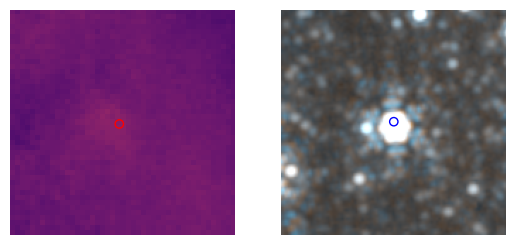

2024-05-29 13:30:21,382 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:21,384 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



17


2024-05-29 13:30:22,486 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


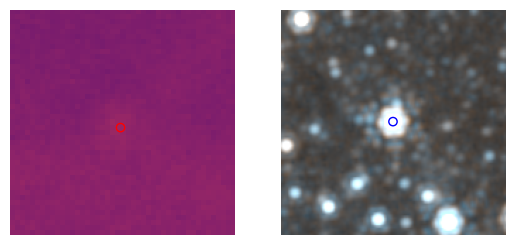

2024-05-29 13:30:22,608 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:22,610 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



18


2024-05-29 13:30:23,567 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


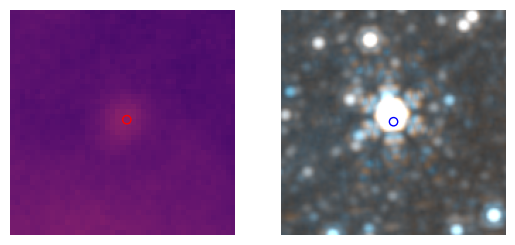

2024-05-29 13:30:23,731 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:23,744 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



19


2024-05-29 13:30:24,611 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


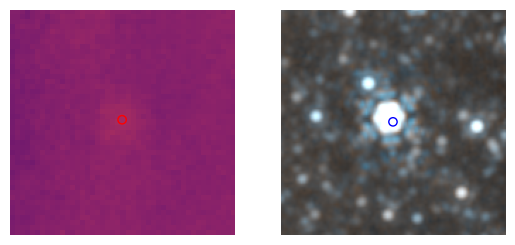

2024-05-29 13:30:24,694 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:24,696 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



20


2024-05-29 13:30:25,915 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


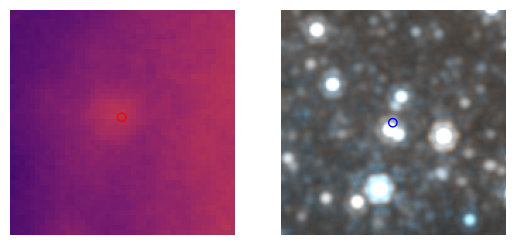

2024-05-29 13:30:26,139 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:26,144 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



21


2024-05-29 13:30:27,342 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


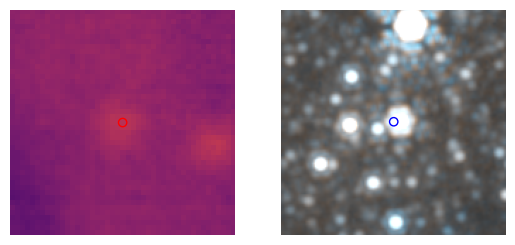

2024-05-29 13:30:27,517 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:27,519 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



22


2024-05-29 13:30:28,595 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


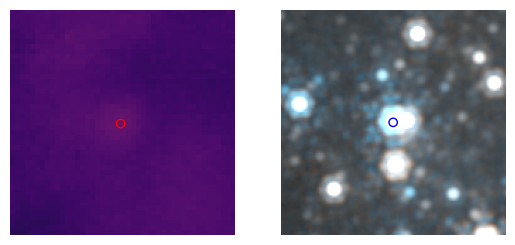

2024-05-29 13:30:28,726 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:28,728 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



23


2024-05-29 13:30:29,868 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


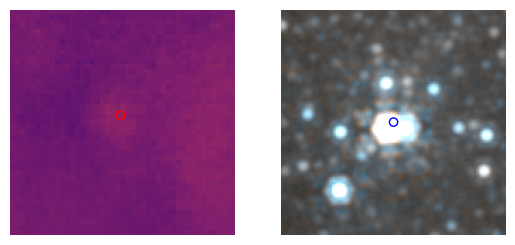

2024-05-29 13:30:30,059 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:30,065 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



24


2024-05-29 13:30:31,376 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


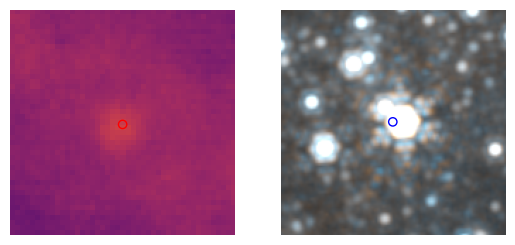

2024-05-29 13:30:31,546 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:31,548 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



25


2024-05-29 13:30:32,445 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


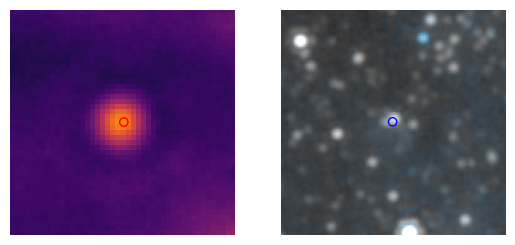

2024-05-29 13:30:32,725 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:32,729 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



26


2024-05-29 13:30:33,976 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


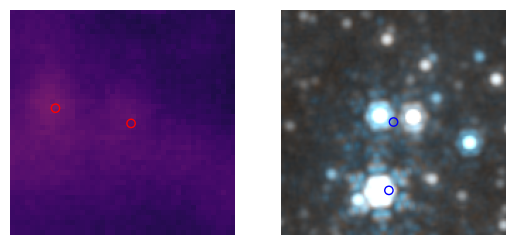

2024-05-29 13:30:34,206 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:34,208 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



27


2024-05-29 13:30:36,803 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


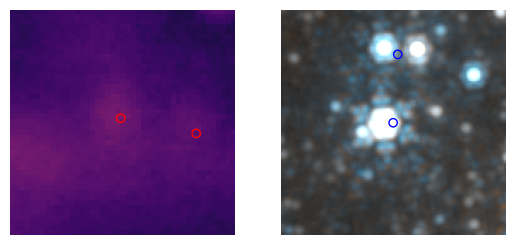

2024-05-29 13:30:37,434 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:37,438 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



28


2024-05-29 13:30:38,963 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


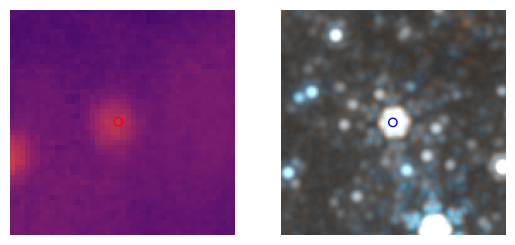

2024-05-29 13:30:39,125 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:39,128 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



29


2024-05-29 13:30:40,346 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


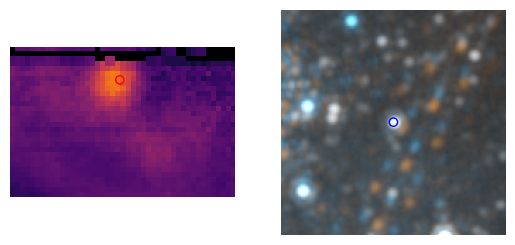

2024-05-29 13:30:40,478 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:40,479 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



30


2024-05-29 13:30:41,612 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


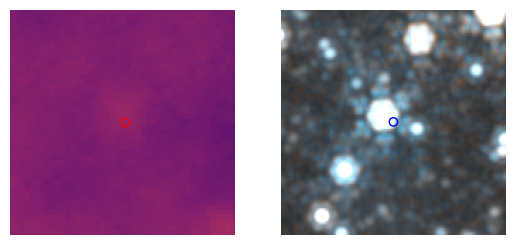

2024-05-29 13:30:41,711 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:41,713 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



31


2024-05-29 13:30:42,561 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


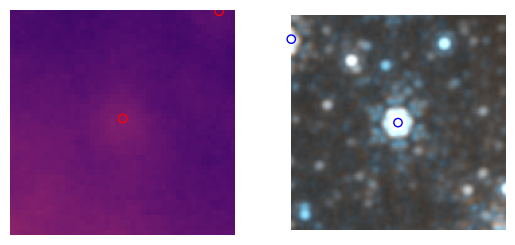

2024-05-29 13:30:42,651 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:42,653 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



32


2024-05-29 13:30:43,636 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


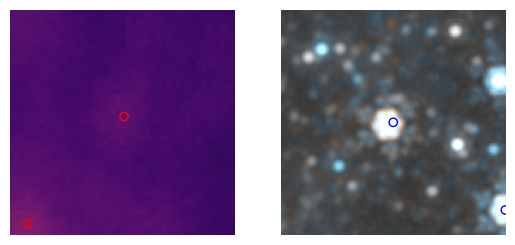

2024-05-29 13:30:43,900 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:43,902 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



33


2024-05-29 13:30:44,906 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


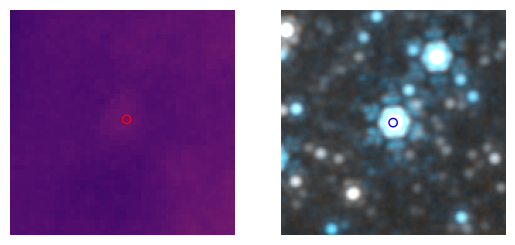

2024-05-29 13:30:45,069 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:45,071 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



34


2024-05-29 13:30:46,236 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


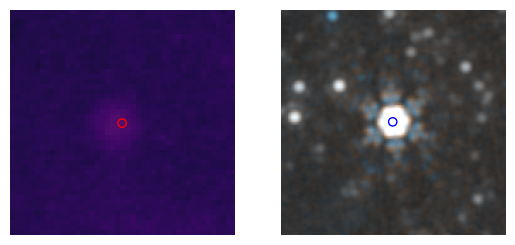

2024-05-29 13:30:46,459 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:46,462 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



35


2024-05-29 13:30:47,957 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


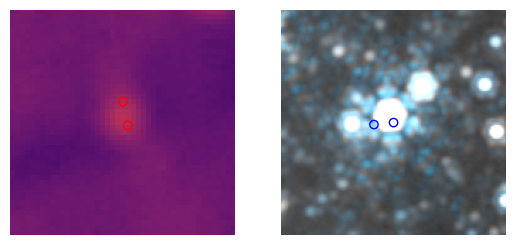

2024-05-29 13:30:48,154 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:48,156 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



36


2024-05-29 13:30:49,035 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


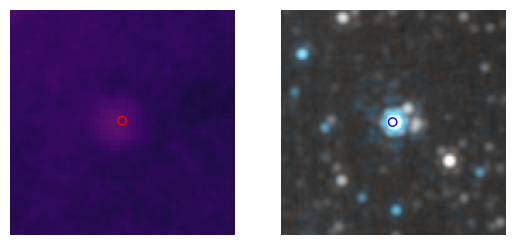

2024-05-29 13:30:49,477 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:49,481 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



37


2024-05-29 13:30:50,454 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


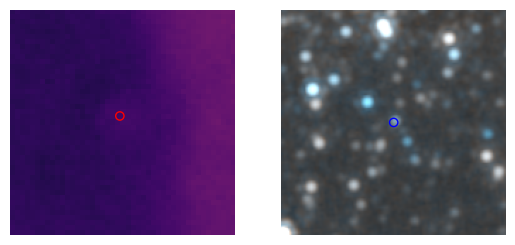

2024-05-29 13:30:50,588 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:50,589 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



38


2024-05-29 13:30:51,804 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


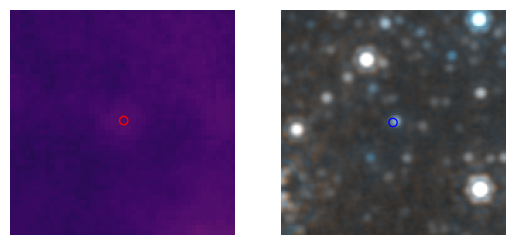

2024-05-29 13:30:51,975 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:51,977 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



39


2024-05-29 13:30:53,158 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


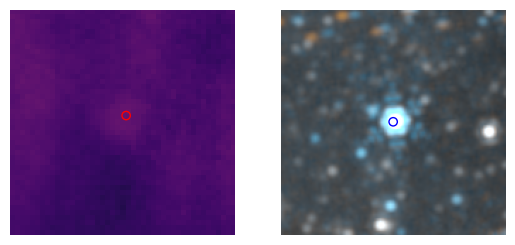

2024-05-29 13:30:53,426 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:53,430 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



40


2024-05-29 13:30:54,785 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


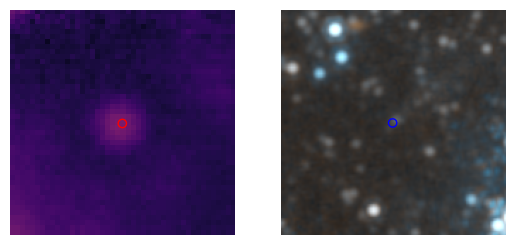

2024-05-29 13:30:55,061 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:55,063 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



41


2024-05-29 13:30:56,303 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


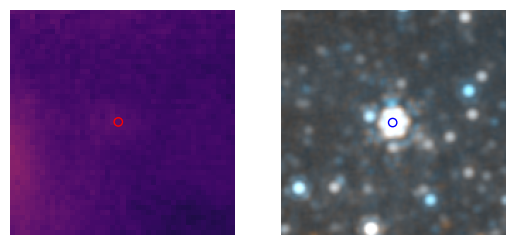

2024-05-29 13:30:56,408 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:56,410 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



42


2024-05-29 13:30:57,528 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


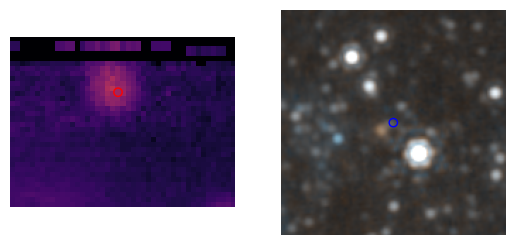

2024-05-29 13:30:57,755 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-08-28T00:33:00.989' from MJD-BEG.
Set DATE-AVG to '2022-08-28T02:01:55.860' from MJD-AVG.
Set DATE-END to '2022-08-28T03:33:29.445' from MJD-END'.
  warnings.warn(

2024-05-29 13:30:57,757 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -51.587046 from OBSGEO-[XYZ].
Set OBSGEO-B to   -20.717935 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527070945.011 from OBSGEO-[XYZ]'.
  warnings.warn(



43


2024-05-29 13:30:58,845 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


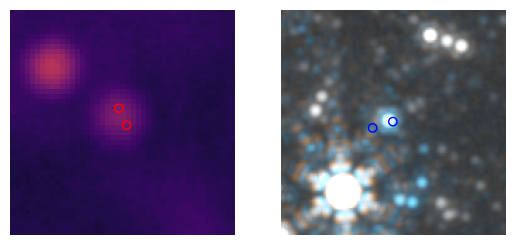

In [11]:
filename = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o001_t001_miri_f2550w_i2d.fits'
#position = crds_use[0]
l = w = 5*u.arcsec
i=0
for position in crds_use:
    print(i)
    i += 1
    cutout = get_cutout(filename, position, l, w)
    ax = plt.subplot(121, projection=cutout.wcs)
    ax.imshow(cutout.data, cmap='inferno', vmin=850, vmax=1000)

    reg = regions.RectangleSkyRegion(center=position, width=l, height=w)
    cat_use_in = cat_use[reg.contains(crds_use, wcs=cutout.wcs)]

    ax.scatter(cat_use_in['skycoord_f2550w'].ra, cat_use_in['skycoord_f2550w'].dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
    ax.set_axis_off()

    cutout_rgb, cutout_rgb_ww = get_cutout_rgb(position, l, w)
    ax_1 = plt.subplot(122, projection=cutout_rgb_ww)
    ax_1.imshow(cutout_rgb)

    ax_1.scatter(cat_use_in['skycoord_ref'].ra, cat_use_in['skycoord_ref'].dec, edgecolor='b', facecolor='none', transform=ax_1.get_transform('world'))

    ax_1.set_axis_off()
    plt.show()

# Color-Magnitude Diagrams

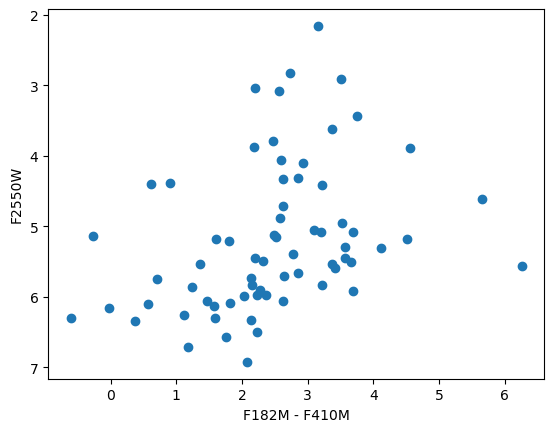

In [30]:
color = cat_use['mag_ab_f182m'] - cat_use['mag_ab_f410m']
mag = cat_use['mag_ab_f2550w']

ax = plt.subplot(111)
ax.scatter(color, mag)
ax.set_xlabel('F182M - F410M')
ax.set_ylabel('F2550W')
plt.gca().invert_yaxis()
print()

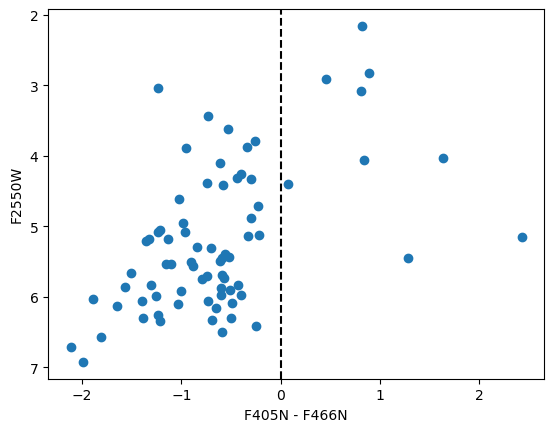

In [32]:
color = cat_use['mag_ab_f405n'] - cat_use['mag_ab_f466n']
mag = cat_use['mag_ab_f2550w']

ax = plt.subplot(111)
ax.scatter(color, mag)
ax.set_xlabel('F405N - F466N')
ax.set_ylabel('F2550W')
ax.axvline(0, color='k', ls='--')
plt.gca().invert_yaxis()
print()

In [60]:
pos = SkyCoord('17:46:21.8876656170', '-28:35:25.8542495344', unit=(u.hourangle, u.deg))
#crds_use.search_around_sky(pos, 1*u.deg)
green_thing_mask = pos.separation(crds_use) < 1.5*u.arcsec
green_thing = cat_use[green_thing_mask]
green_thing

<Table length=1>
             skycoord_ref             skycoord_ref_filtername       sep_f410m        id_f410m ... emag_ab_f2550w   sep_f2550w_f2550w    id_f2550w_f2550w
               deg,deg                                                 deg                    ...                         deg                           
               SkyCoord                        bytes5                float64          int64   ...    float32            float64              int64      
------------------------------------- ----------------------- ---------------------- -------- ... -------------- ---------------------- ----------------
266.5911468769552,-28.590495385698997                   f405n 3.6419495184260876e-05    40907 ...    0.006712107 2.3166988367594597e-05            64434

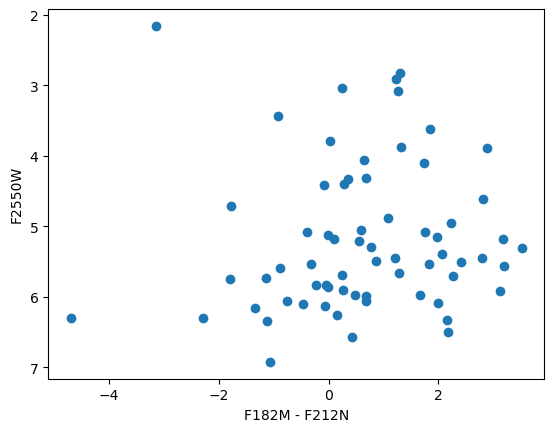

In [54]:
color = cat_use['mag_ab_f182m'] - cat_use['mag_ab_f212n']
mag = cat_use['mag_ab_f2550w']

ax = plt.subplot(111)
ax.scatter(color, mag)
ax.set_xlabel('F182M - F212N')
ax.set_ylabel('F2550W')
#ax.axvline(0, color='k', ls='--')
plt.gca().invert_yaxis()
print()

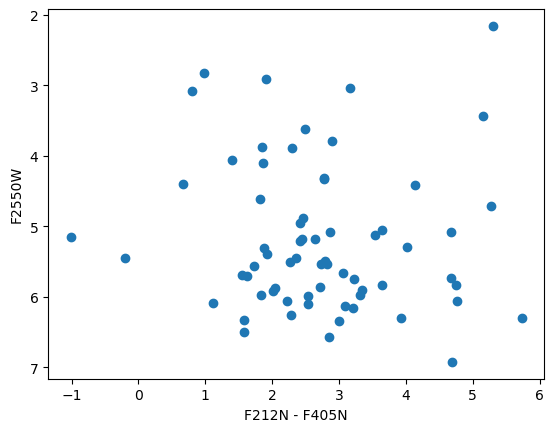

In [70]:
color = cat_use['mag_ab_f212n'] - cat_use['mag_ab_f405n']
mag = cat_use['mag_ab_f2550w']

ax = plt.subplot(111)
ax.scatter(color, mag)
ax.set_xlabel('F212N - F405N')
ax.set_ylabel('F2550W')
#ax.axvline(0, color='k', ls='--')
plt.gca().invert_yaxis()
print()

# Color-Color Diagrams

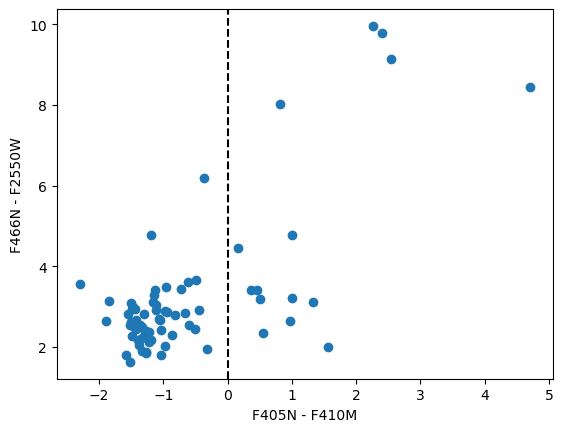

In [67]:
color1 = cat_use['mag_ab_f405n'] - cat_use['mag_ab_f410m']
color2 = cat_use['mag_ab_f466n'] - cat_use['mag_ab_f2550w']

ax = plt.subplot(111)
ax.scatter(color1, color2)
ax.set_xlabel('F405N - F410M')
ax.set_ylabel('F466N - F2550W')
ax.axvline(0, color='k', ls='--')
#plt.gca().invert_yaxis()
print()

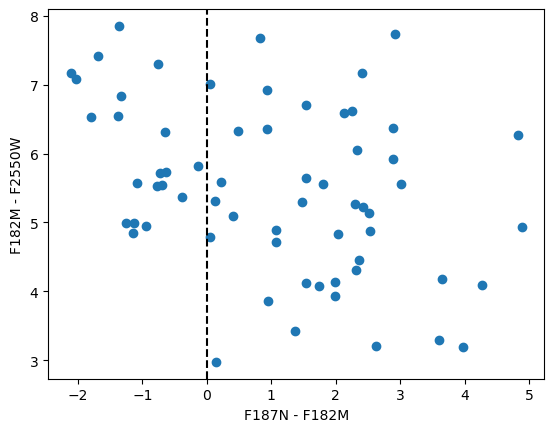

In [69]:
color1 = cat_use['mag_ab_f187n'] - cat_use['mag_ab_f182m']
color2 = cat_use['mag_ab_f182m'] - cat_use['mag_ab_f2550w']

ax = plt.subplot(111)
ax.scatter(color1, color2)
ax.set_xlabel('F187N - F182M')
ax.set_ylabel('F182M - F2550W')
ax.axvline(0, color='k', ls='--')
#plt.gca().invert_yaxis()
print()

# SEDs